In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from sklearn.model_selection import train_test_split



# Import Keras
import keras as K
from keras.models import load_model, Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.applications import Xception, ResNet50V2
from keras.applications.xception import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.losses import CategoricalCrossentropy


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # ✅ Active la gestion dynamique de mémoire
    except RuntimeError as e:
        print(e)


In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
train = unpickle("cifar-100-python\\train")
test = unpickle("cifar-100-python\\test")
meta = unpickle("cifar-100-python\\meta")

In [6]:
print(train[b'data'].shape)

(50000, 3072)


In [7]:
def display_rd_img(dataset):
    load = dataset[b'data']
    num = rd.randint(0, len(load))
    title = str(dataset[b'filenames'][num])
    title = title.split("\'")[1].split("_s_")[0]
    img = load[num]
    img = img.reshape((3,32,32))
    img = img.transpose(1,2,0)
    print(type(img))
    plt.imshow(img)
    plt.title(title)


<class 'numpy.ndarray'>


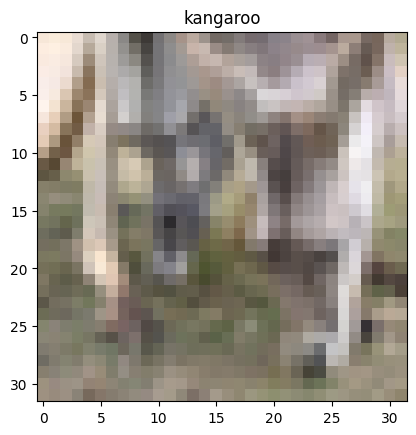

In [8]:
display_rd_img(train)

In [9]:
def pre_process(dataset):
    data = dataset[b'data']
    result = []
    for i in range(0, len(data)):
        temp = data[i].reshape((3,32,32))
        temp= temp.transpose(1,2,0)
        result.append(temp)
    return result

p_train = pre_process(train)    

In [10]:
trained_label = train[b'fine_labels']

In [11]:
print(len(p_train))

50000


In [12]:
class CIFAR100Generator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32, shuffle=True, num_classes=100, augment=False):
        self.images = np.array(images, dtype=np.float32) 
        self.labels = np.array(labels, dtype=np.int32)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.augment = augment  # Activation ou non de l'augmentation
        self.indices = np.arange(len(self.images))
        self.images = preprocess_input(self.images)  
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.images) // self.batch_size  # Nombre total de batchs par epoch

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_labels = self.labels[batch_indices]

        # Convertir les labels en one-hot encoding
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        # Appliquer l'augmentation uniquement pour l'entraînement
        if self.augment:
            batch_images = self.augment_images(batch_images)

        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def augment_images(self, batch_images):
        batch_images_aug = []
        for img in batch_images:
            if np.random.rand() > 0.5:  # 50% des images restent inchangées
                batch_images_aug.append(img)
            else:
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_brightness(img, max_delta=0.2)
                img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
                img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
                img = tf.image.rot90(img, k=np.random.randint(4))
                img = tf.image.resize_with_crop_or_pad(img, 36, 36)
                img = tf.image.random_crop(img, size=[32, 32, 3])
                batch_images_aug.append(img)
        
        return np.array(batch_images_aug, dtype=np.float32)



def create_generators(images, labels, batch_size=32, val_split=0.2):
    """
    Sépare les données en train/val et retourne deux générateurs.
    """
    # Séparation des données en train et validation
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=val_split, random_state=42)

    # Création des générateurs
    train_generator = CIFAR100Generator(X_train, y_train, batch_size=batch_size, shuffle=True, augment=True)  # Augmentation activée
    val_generator = CIFAR100Generator(X_val, y_val, batch_size=batch_size, shuffle=False, augment=False)  # Pas d'augmentation pour validation
    
    return train_generator, val_generator



def create_test_generator(images, labels, batch_size=32):
    # Création des générateurs
    test_generator = CIFAR100Generator(images, labels, batch_size=batch_size, shuffle=False, augment=False)  # Pas d'augmentation pour validation
    
    return test_generator


In [13]:
train_generator, val_generator = create_generators(p_train, trained_label, batch_size=32)

In [14]:

x_batch, y_batch = train_generator[0]
print("Shape des images:", x_batch.shape)  # Doit être (batch_size, 32, 32, 3)
print("Shape des labels:", y_batch.shape)  # Doit être (batch_size, 100)


Shape des images: (32, 32, 32, 3)
Shape des labels: (32, 100)


In [15]:
class HardExampleMining(Callback):
    def __init__(self, train_generator, percentile=50):
        super(HardExampleMining, self).__init__()
        self.train_generator = train_generator  # Générateur de données
        self.percentile = percentile  # Seuil pour les hard examples
        self.loss_fn = CategoricalCrossentropy()

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n🔍 Analyse des hard examples après l'époque {epoch}...")

        X_train, y_train = [], []
        for i in range(len(self.train_generator)):
            X_batch, y_batch = self.train_generator[i]
            X_train.append(X_batch)
            y_train.append(y_batch)

        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        y_pred = self.model.predict(X_train, verbose=0)
        losses = K.losses.categorical_crossentropy(y_train, y_pred).numpy()

        # ✅ Correction : Ne pas enlever trop d'exemples
        threshold = np.percentile(losses, self.percentile)
        hard_indices = np.where(losses > threshold)[0]

        # ✅ Si aucun exemple n'est sélectionné, prendre les 10% pires
        if len(hard_indices) == 0:
            hard_indices = np.argsort(losses)[-max(10, len(losses) // 10):]

        print(f"📌 {len(hard_indices)} exemples sélectionnés (seuil = {threshold:.4f})")

        print(f"🔍 Analyse des prédictions après l'époque {epoch}:")
        print(f"  - Probabilité moyenne max : {np.mean(np.max(y_pred, axis=1)):.4f}")
        print(f"  - Écart-type des probas max : {np.std(np.max(y_pred, axis=1)):.4f}")


        plt.hist(losses, bins=30)
        plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
        plt.xlabel("Valeur de la perte")
        plt.ylabel("Nombre d'exemples")
        plt.title("Distribution des pertes")
        plt.show()




In [16]:
def neural_net(num_neurones,num_hidden_layers,dropout_rate, early_stop_patience, lr_scheduler_patience, train_generator,learning_rate= 0.0001):
    #base_model = Xception(weights='imagenet', include_top=False)
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(32,32,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    # Ajouter des couches personnalisées
    for _ in range (0, num_hidden_layers): 
        x = Dense(num_neurones, activation='relu')(x)  # Ajouter une couche Dense pour l'apprentissage des caractéristiques
        #x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)  # Ajouter une couche de dropout pour réduire le surapprentissage
    predictions = Dense(100, activation='softmax')(x)  # Couche de sortie pour 100 classes

    # Configurer les callbacks
    checkpoint = ModelCheckpoint("test.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stop_patience, verbose=1, mode='auto')
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=lr_scheduler_patience)
    hardExample = HardExampleMining(train_generator)  # Ajout du callback Hard Example Mining
    callbacks = [checkpoint, early, lr_scheduler, hardExample]

    # Créer l'instance de l'optimiseur avec le learning rate spécifié
    optimizer = Adam(learning_rate=learning_rate)
    #optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)


    # Compiler le modèle avec l'optimiseur configuré
    model = Model(inputs= base_model.input , outputs=predictions)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
    return model, callbacks

# Entraîner le modèle
def training(model, cb, n_epoch):
    history = model.fit(
        train_generator,
        epochs=n_epoch,
        validation_data=val_generator,
        callbacks=cb)
    
    model.save('test_final.h5')
    return history

def plot_history(history):
    # Tracer la précision et la perte
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Epoch 1/200
1250/1250 [==============================] - ETA: 0s - loss: 4.6023 - accuracy: 0.0144
Epoch 1: val_loss improved from inf to 4.59868, saving model to test.h5

🔍 Analyse des hard examples après l'époque 0...
📌 19897 exemples sélectionnés (seuil = 4.6009)
🔍 Analyse des prédictions après l'époque 0:
  - Probabilité moyenne max : 0.0282
  - Écart-type des probas max : 0.0737


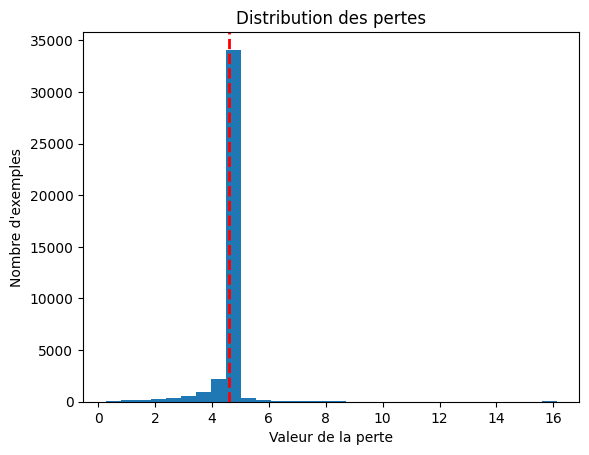

1250/1250 [==============================] - 210s 156ms/step - loss: 4.6023 - accuracy: 0.0144 - val_loss: 4.5987 - val_accuracy: 0.0254 - lr: 1.0000e-04
Epoch 2/200
1250/1250 [==============================] - ETA: 0s - loss: 4.4716 - accuracy: 0.0323
Epoch 2: val_loss improved from 4.59868 to 4.29299, saving model to test.h5

🔍 Analyse des hard examples après l'époque 1...
📌 20000 exemples sélectionnés (seuil = 4.5661)
🔍 Analyse des prédictions après l'époque 1:
  - Probabilité moyenne max : 0.0522
  - Écart-type des probas max : 0.1102


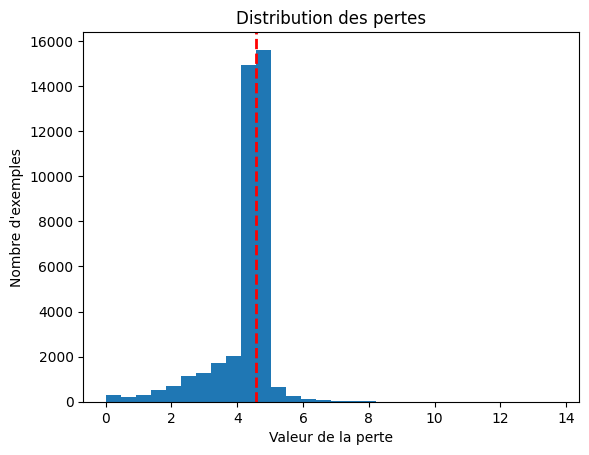

1250/1250 [==============================] - 195s 156ms/step - loss: 4.4716 - accuracy: 0.0323 - val_loss: 4.2930 - val_accuracy: 0.0693 - lr: 1.0000e-04
Epoch 3/200
1250/1250 [==============================] - ETA: 0s - loss: 4.2547 - accuracy: 0.0670
Epoch 3: val_loss improved from 4.29299 to 3.96470, saving model to test.h5

🔍 Analyse des hard examples après l'époque 2...
📌 20000 exemples sélectionnés (seuil = 4.3377)
🔍 Analyse des prédictions après l'époque 2:
  - Probabilité moyenne max : 0.0785
  - Écart-type des probas max : 0.1413


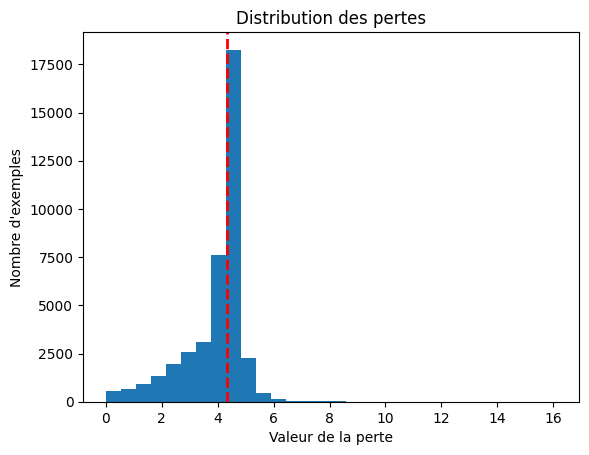

1250/1250 [==============================] - 195s 156ms/step - loss: 4.2547 - accuracy: 0.0670 - val_loss: 3.9647 - val_accuracy: 0.1156 - lr: 1.0000e-04
Epoch 4/200
1250/1250 [==============================] - ETA: 0s - loss: 4.0158 - accuracy: 0.1014
Epoch 4: val_loss improved from 3.96470 to 3.66776, saving model to test.h5

🔍 Analyse des hard examples après l'époque 3...
📌 20000 exemples sélectionnés (seuil = 3.8990)
🔍 Analyse des prédictions après l'époque 3:
  - Probabilité moyenne max : 0.1289
  - Écart-type des probas max : 0.1815


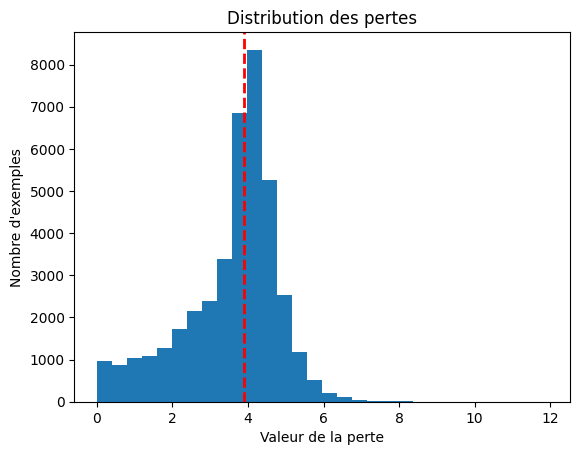

1250/1250 [==============================] - 194s 155ms/step - loss: 4.0158 - accuracy: 0.1014 - val_loss: 3.6678 - val_accuracy: 0.1717 - lr: 1.0000e-04
Epoch 5/200
1250/1250 [==============================] - ETA: 0s - loss: 3.8460 - accuracy: 0.1406
Epoch 5: val_loss improved from 3.66776 to 3.53268, saving model to test.h5

🔍 Analyse des hard examples après l'époque 4...
📌 20000 exemples sélectionnés (seuil = 3.7532)
🔍 Analyse des prédictions après l'époque 4:
  - Probabilité moyenne max : 0.1675
  - Écart-type des probas max : 0.2115


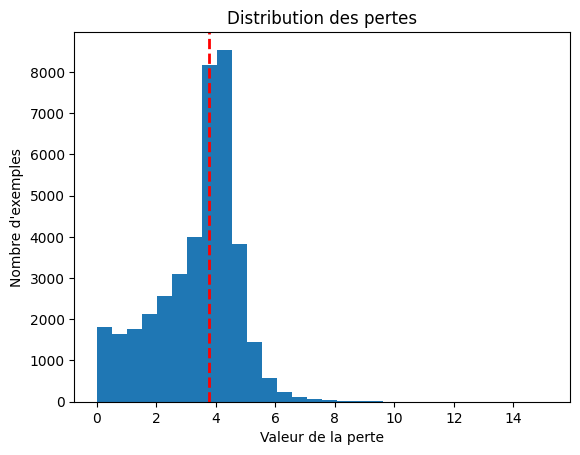

1250/1250 [==============================] - 195s 156ms/step - loss: 3.8460 - accuracy: 0.1406 - val_loss: 3.5327 - val_accuracy: 0.2059 - lr: 1.0000e-04
Epoch 6/200
1250/1250 [==============================] - ETA: 0s - loss: 3.7107 - accuracy: 0.1664
Epoch 6: val_loss improved from 3.53268 to 3.34888, saving model to test.h5

🔍 Analyse des hard examples après l'époque 5...
📌 20000 exemples sélectionnés (seuil = 3.5072)
🔍 Analyse des prédictions après l'époque 5:
  - Probabilité moyenne max : 0.1950
  - Écart-type des probas max : 0.2302


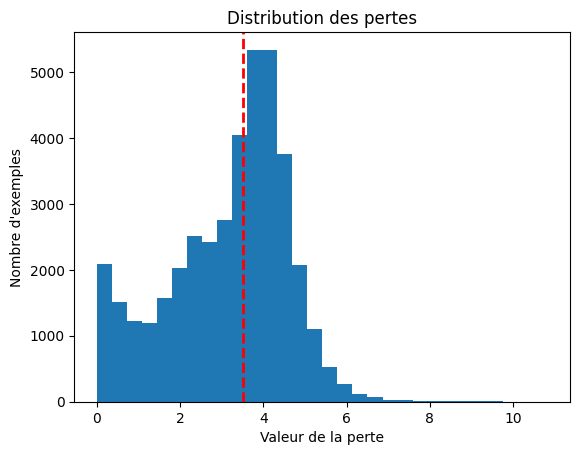

1250/1250 [==============================] - 194s 155ms/step - loss: 3.7107 - accuracy: 0.1664 - val_loss: 3.3489 - val_accuracy: 0.2399 - lr: 1.0000e-04
Epoch 7/200
1250/1250 [==============================] - ETA: 0s - loss: 3.6277 - accuracy: 0.1902
Epoch 7: val_loss improved from 3.34888 to 3.30191, saving model to test.h5

🔍 Analyse des hard examples après l'époque 6...
📌 20000 exemples sélectionnés (seuil = 3.4268)
🔍 Analyse des prédictions après l'époque 6:
  - Probabilité moyenne max : 0.2090
  - Écart-type des probas max : 0.2411


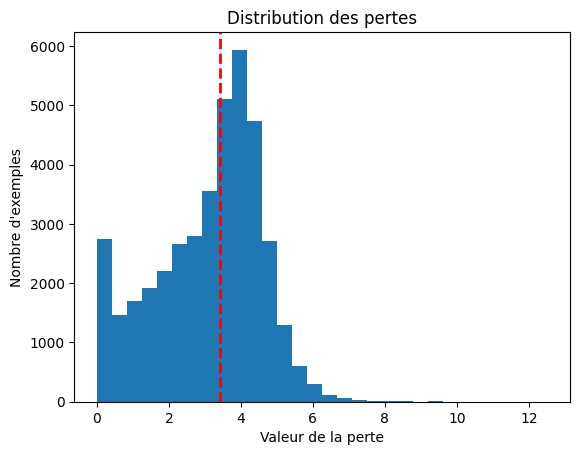

1250/1250 [==============================] - 197s 157ms/step - loss: 3.6277 - accuracy: 0.1902 - val_loss: 3.3019 - val_accuracy: 0.2580 - lr: 1.0000e-04
Epoch 8/200
1250/1250 [==============================] - ETA: 0s - loss: 3.5308 - accuracy: 0.2166
Epoch 8: val_loss improved from 3.30191 to 3.18489, saving model to test.h5

🔍 Analyse des hard examples après l'époque 7...
📌 20000 exemples sélectionnés (seuil = 3.2319)
🔍 Analyse des prédictions après l'époque 7:
  - Probabilité moyenne max : 0.2426
  - Écart-type des probas max : 0.2586


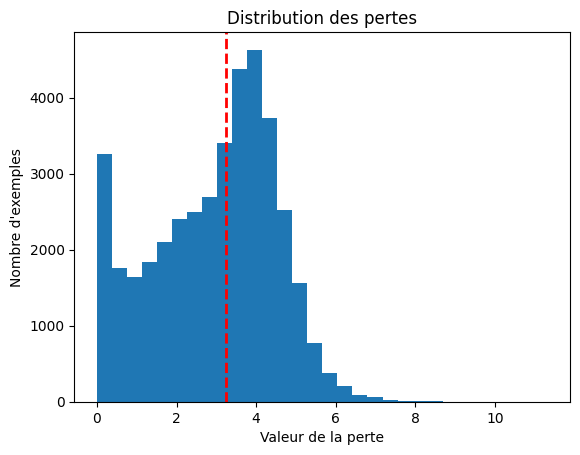

1250/1250 [==============================] - 203s 162ms/step - loss: 3.5308 - accuracy: 0.2166 - val_loss: 3.1849 - val_accuracy: 0.2894 - lr: 1.0000e-04
Epoch 9/200
1250/1250 [==============================] - ETA: 0s - loss: 3.4323 - accuracy: 0.2383
Epoch 9: val_loss improved from 3.18489 to 3.08965, saving model to test.h5

🔍 Analyse des hard examples après l'époque 8...
📌 20000 exemples sélectionnés (seuil = 3.0609)
🔍 Analyse des prédictions après l'époque 8:
  - Probabilité moyenne max : 0.2538
  - Écart-type des probas max : 0.2582


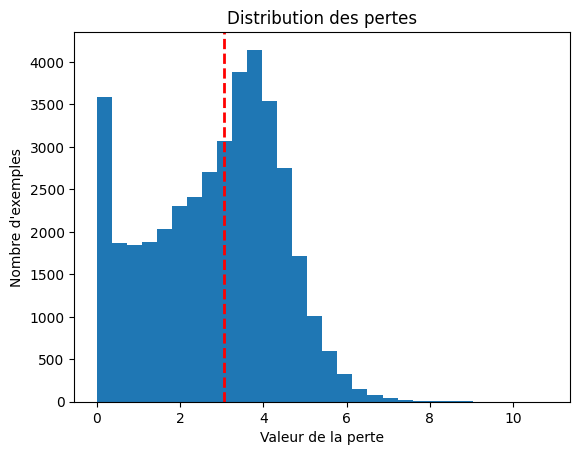

1250/1250 [==============================] - 198s 158ms/step - loss: 3.4323 - accuracy: 0.2383 - val_loss: 3.0897 - val_accuracy: 0.3116 - lr: 1.0000e-04
Epoch 10/200
1250/1250 [==============================] - ETA: 0s - loss: 3.3445 - accuracy: 0.2575
Epoch 10: val_loss improved from 3.08965 to 2.99897, saving model to test.h5

🔍 Analyse des hard examples après l'époque 9...
📌 20000 exemples sélectionnés (seuil = 2.8538)
🔍 Analyse des prédictions après l'époque 9:
  - Probabilité moyenne max : 0.2768
  - Écart-type des probas max : 0.2686


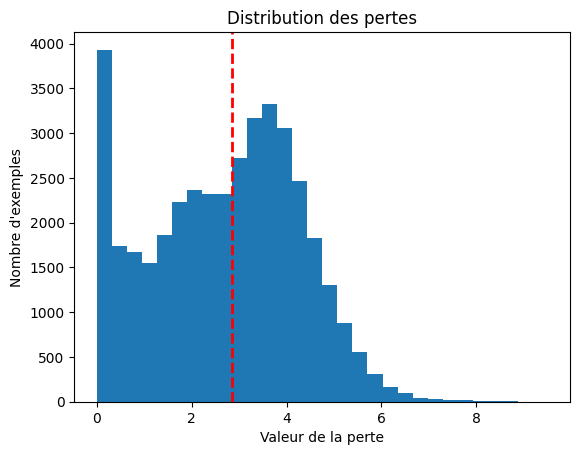

1250/1250 [==============================] - 198s 158ms/step - loss: 3.3445 - accuracy: 0.2575 - val_loss: 2.9990 - val_accuracy: 0.3331 - lr: 1.0000e-04
Epoch 11/200
1250/1250 [==============================] - ETA: 0s - loss: 3.2685 - accuracy: 0.2796
Epoch 11: val_loss improved from 2.99897 to 2.93520, saving model to test.h5

🔍 Analyse des hard examples après l'époque 10...
📌 20000 exemples sélectionnés (seuil = 2.6751)
🔍 Analyse des prédictions après l'époque 10:
  - Probabilité moyenne max : 0.3008
  - Écart-type des probas max : 0.2736


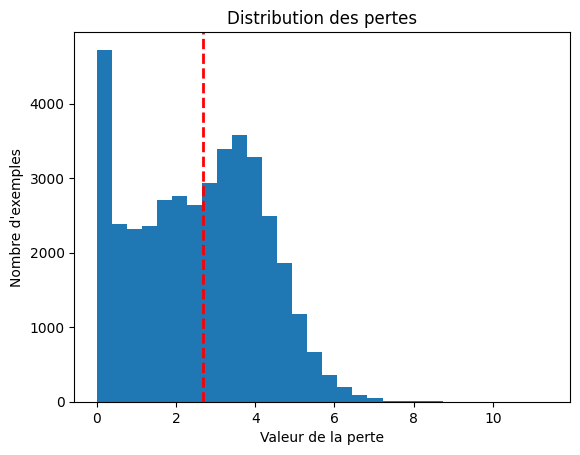

1250/1250 [==============================] - 196s 156ms/step - loss: 3.2685 - accuracy: 0.2796 - val_loss: 2.9352 - val_accuracy: 0.3531 - lr: 1.0000e-04
Epoch 12/200
1250/1250 [==============================] - ETA: 0s - loss: 3.2005 - accuracy: 0.2973
Epoch 12: val_loss improved from 2.93520 to 2.87866, saving model to test.h5

🔍 Analyse des hard examples après l'époque 11...
📌 20000 exemples sélectionnés (seuil = 2.5676)
🔍 Analyse des prédictions après l'époque 11:
  - Probabilité moyenne max : 0.3116
  - Écart-type des probas max : 0.2737


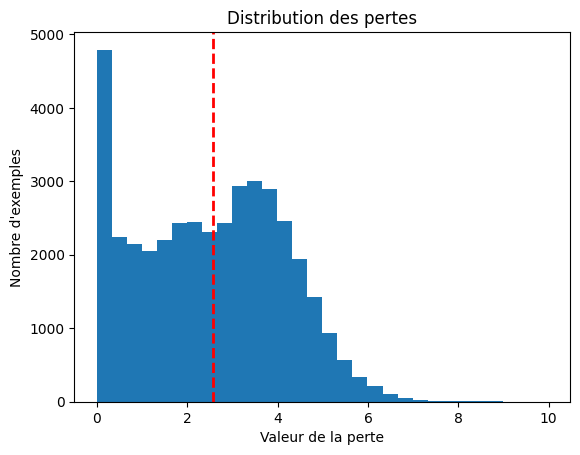

1250/1250 [==============================] - 196s 157ms/step - loss: 3.2005 - accuracy: 0.2973 - val_loss: 2.8787 - val_accuracy: 0.3701 - lr: 1.0000e-04
Epoch 13/200
1250/1250 [==============================] - ETA: 0s - loss: 3.1379 - accuracy: 0.3173
Epoch 13: val_loss improved from 2.87866 to 2.82456, saving model to test.h5

🔍 Analyse des hard examples après l'époque 12...
📌 20000 exemples sélectionnés (seuil = 2.4506)
🔍 Analyse des prédictions après l'époque 12:
  - Probabilité moyenne max : 0.3259
  - Écart-type des probas max : 0.2734


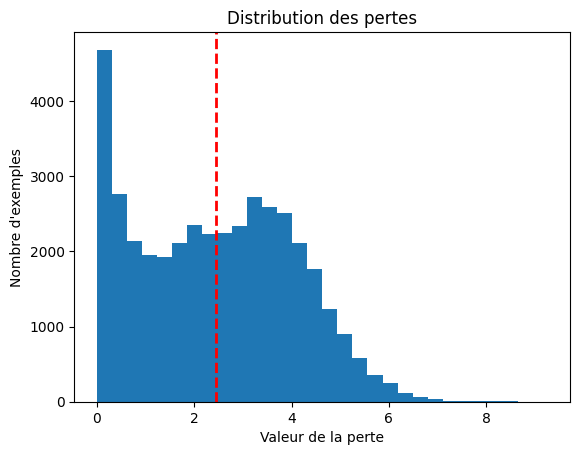

1250/1250 [==============================] - 196s 157ms/step - loss: 3.1379 - accuracy: 0.3173 - val_loss: 2.8246 - val_accuracy: 0.3816 - lr: 1.0000e-04
Epoch 14/200
1250/1250 [==============================] - ETA: 0s - loss: 3.0706 - accuracy: 0.3357
Epoch 14: val_loss improved from 2.82456 to 2.76808, saving model to test.h5

🔍 Analyse des hard examples après l'époque 13...
📌 20000 exemples sélectionnés (seuil = 2.3239)
🔍 Analyse des prédictions après l'époque 13:
  - Probabilité moyenne max : 0.3468
  - Écart-type des probas max : 0.2842


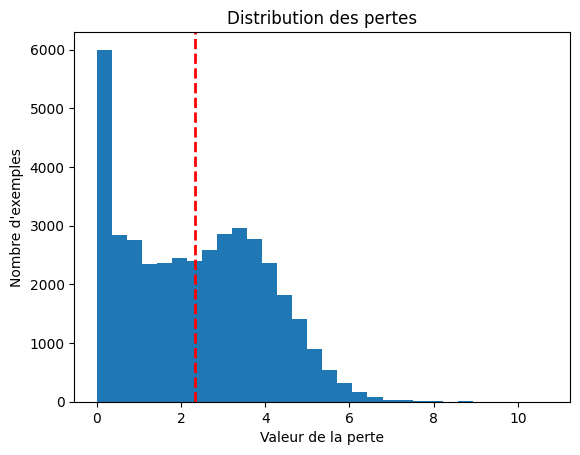

1250/1250 [==============================] - 197s 157ms/step - loss: 3.0706 - accuracy: 0.3357 - val_loss: 2.7681 - val_accuracy: 0.4029 - lr: 1.0000e-04
Epoch 15/200
1250/1250 [==============================] - ETA: 0s - loss: 3.0192 - accuracy: 0.3482
Epoch 15: val_loss improved from 2.76808 to 2.74527, saving model to test.h5

🔍 Analyse des hard examples après l'époque 14...
📌 20000 exemples sélectionnés (seuil = 2.2650)
🔍 Analyse des prédictions après l'époque 14:
  - Probabilité moyenne max : 0.3523
  - Écart-type des probas max : 0.2850


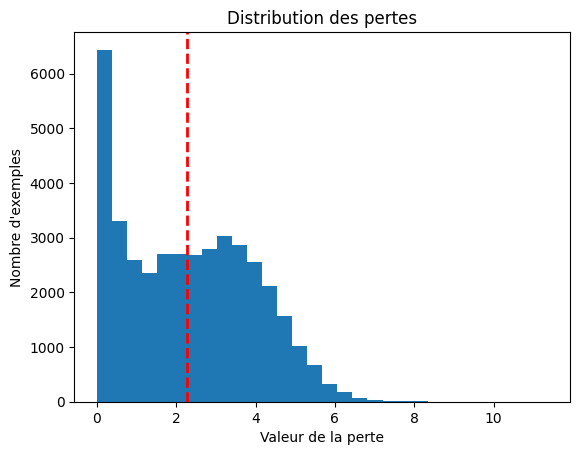

1250/1250 [==============================] - 197s 157ms/step - loss: 3.0192 - accuracy: 0.3482 - val_loss: 2.7453 - val_accuracy: 0.4067 - lr: 1.0000e-04
Epoch 16/200
1250/1250 [==============================] - ETA: 0s - loss: 2.9633 - accuracy: 0.3625
Epoch 16: val_loss improved from 2.74527 to 2.72059, saving model to test.h5

🔍 Analyse des hard examples après l'époque 15...
📌 20000 exemples sélectionnés (seuil = 2.1428)
🔍 Analyse des prédictions après l'époque 15:
  - Probabilité moyenne max : 0.3667
  - Écart-type des probas max : 0.2875


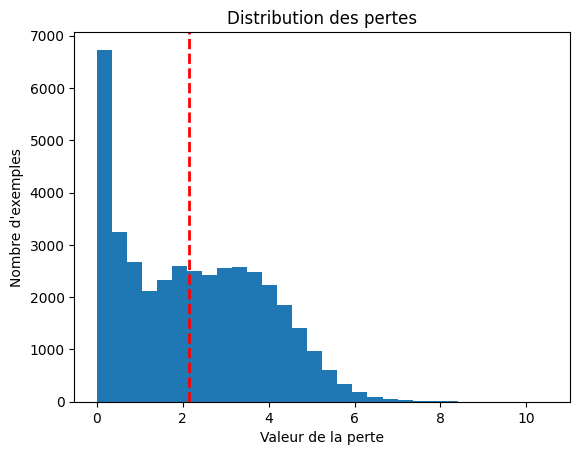

1250/1250 [==============================] - 200s 160ms/step - loss: 2.9633 - accuracy: 0.3625 - val_loss: 2.7206 - val_accuracy: 0.4172 - lr: 1.0000e-04
Epoch 17/200
1250/1250 [==============================] - ETA: 0s - loss: 2.9190 - accuracy: 0.3756
Epoch 17: val_loss improved from 2.72059 to 2.68529, saving model to test.h5

🔍 Analyse des hard examples après l'époque 16...
📌 20000 exemples sélectionnés (seuil = 2.0711)
🔍 Analyse des prédictions après l'époque 16:
  - Probabilité moyenne max : 0.3870
  - Écart-type des probas max : 0.2971


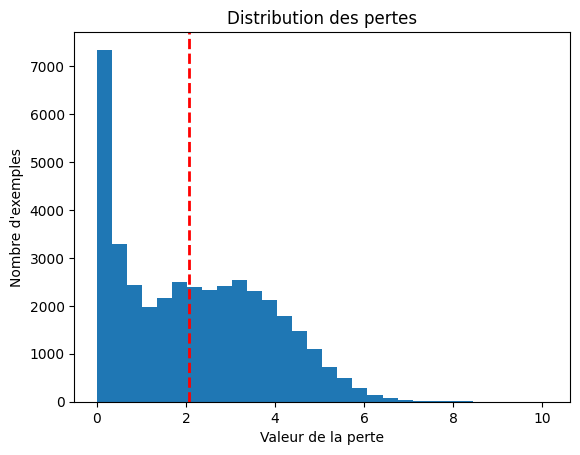

1250/1250 [==============================] - 196s 157ms/step - loss: 2.9190 - accuracy: 0.3756 - val_loss: 2.6853 - val_accuracy: 0.4285 - lr: 1.0000e-04
Epoch 18/200
1250/1250 [==============================] - ETA: 0s - loss: 2.8732 - accuracy: 0.3898
Epoch 18: val_loss improved from 2.68529 to 2.65502, saving model to test.h5

🔍 Analyse des hard examples après l'époque 17...
📌 20000 exemples sélectionnés (seuil = 1.9252)
🔍 Analyse des prédictions après l'époque 17:
  - Probabilité moyenne max : 0.4050
  - Écart-type des probas max : 0.2962


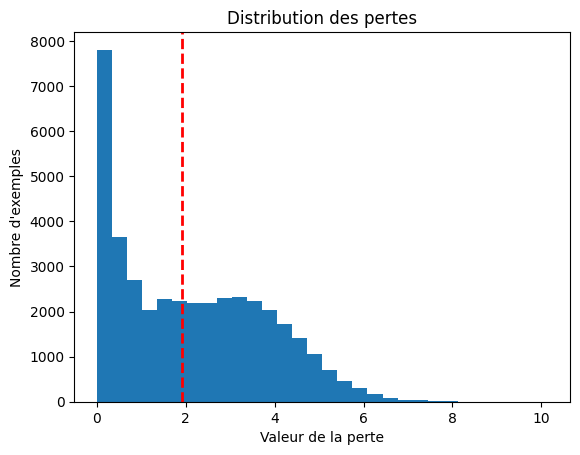

1250/1250 [==============================] - 195s 156ms/step - loss: 2.8732 - accuracy: 0.3898 - val_loss: 2.6550 - val_accuracy: 0.4424 - lr: 1.0000e-04
Epoch 19/200
1250/1250 [==============================] - ETA: 0s - loss: 2.8260 - accuracy: 0.4019
Epoch 19: val_loss improved from 2.65502 to 2.61495, saving model to test.h5

🔍 Analyse des hard examples après l'époque 18...
📌 20000 exemples sélectionnés (seuil = 1.8886)
🔍 Analyse des prédictions après l'époque 18:
  - Probabilité moyenne max : 0.4082
  - Écart-type des probas max : 0.2945


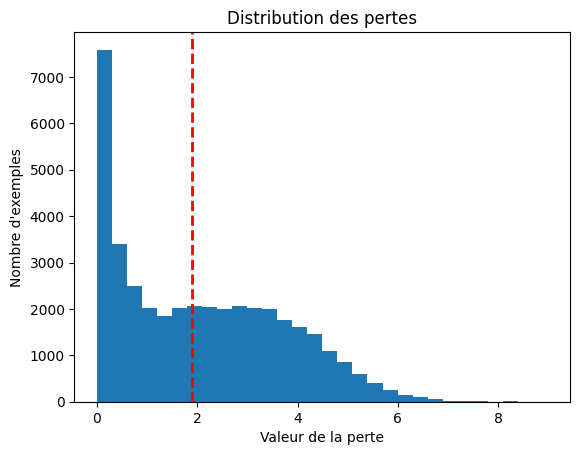

1250/1250 [==============================] - 201s 160ms/step - loss: 2.8260 - accuracy: 0.4019 - val_loss: 2.6150 - val_accuracy: 0.4515 - lr: 1.0000e-04
Epoch 20/200
1250/1250 [==============================] - ETA: 0s - loss: 2.7950 - accuracy: 0.4134
Epoch 20: val_loss did not improve from 2.61495

🔍 Analyse des hard examples après l'époque 19...
📌 20000 exemples sélectionnés (seuil = 1.8137)
🔍 Analyse des prédictions après l'époque 19:
  - Probabilité moyenne max : 0.4226
  - Écart-type des probas max : 0.2986


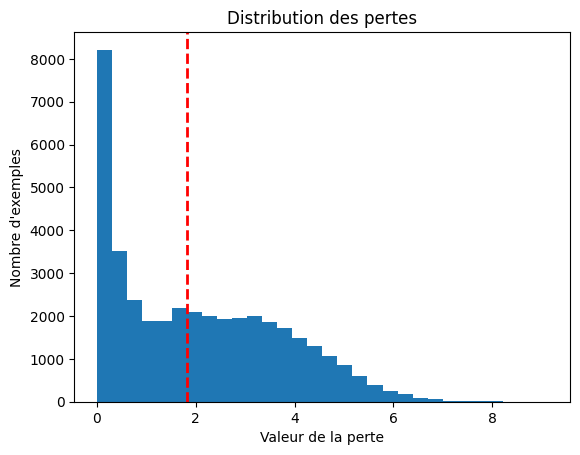

1250/1250 [==============================] - 229s 184ms/step - loss: 2.7950 - accuracy: 0.4134 - val_loss: 2.6346 - val_accuracy: 0.4491 - lr: 1.0000e-04
Epoch 21/200
1250/1250 [==============================] - ETA: 0s - loss: 2.7620 - accuracy: 0.4220
Epoch 21: val_loss improved from 2.61495 to 2.61099, saving model to test.h5

🔍 Analyse des hard examples après l'époque 20...
📌 20000 exemples sélectionnés (seuil = 1.7514)
🔍 Analyse des prédictions après l'époque 20:
  - Probabilité moyenne max : 0.4262
  - Écart-type des probas max : 0.3011


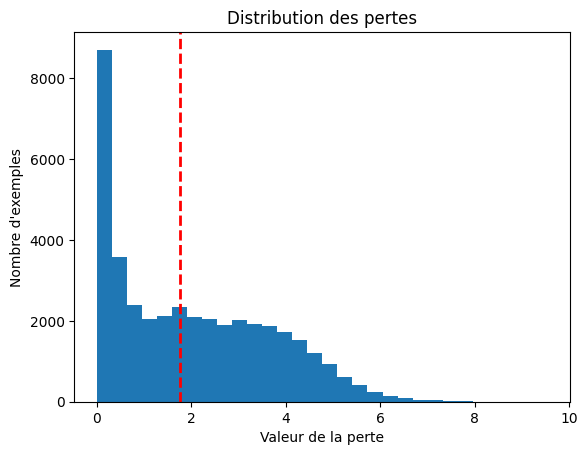

1250/1250 [==============================] - 225s 180ms/step - loss: 2.7620 - accuracy: 0.4220 - val_loss: 2.6110 - val_accuracy: 0.4592 - lr: 1.0000e-04
Epoch 22/200
1250/1250 [==============================] - ETA: 0s - loss: 2.7197 - accuracy: 0.4336
Epoch 22: val_loss improved from 2.61099 to 2.57502, saving model to test.h5

🔍 Analyse des hard examples après l'époque 21...
📌 20000 exemples sélectionnés (seuil = 1.6710)
🔍 Analyse des prédictions après l'époque 21:
  - Probabilité moyenne max : 0.4503
  - Écart-type des probas max : 0.3040


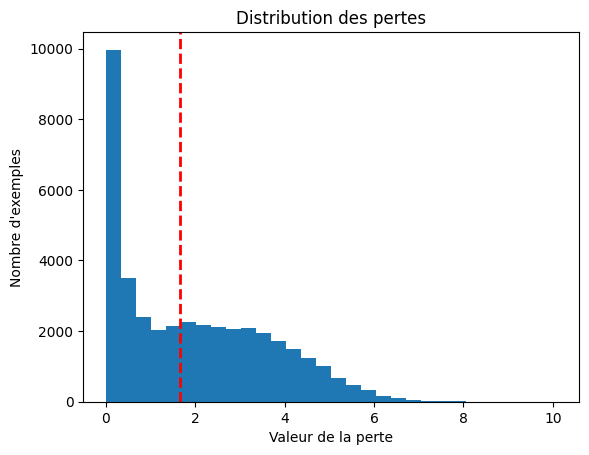

1250/1250 [==============================] - 272s 217ms/step - loss: 2.7197 - accuracy: 0.4336 - val_loss: 2.5750 - val_accuracy: 0.4590 - lr: 1.0000e-04
Epoch 23/200
1250/1250 [==============================] - ETA: 0s - loss: 2.6920 - accuracy: 0.4421
Epoch 23: val_loss improved from 2.57502 to 2.56097, saving model to test.h5

🔍 Analyse des hard examples après l'époque 22...
📌 20000 exemples sélectionnés (seuil = 1.6441)
🔍 Analyse des prédictions après l'époque 22:
  - Probabilité moyenne max : 0.4386
  - Écart-type des probas max : 0.2994


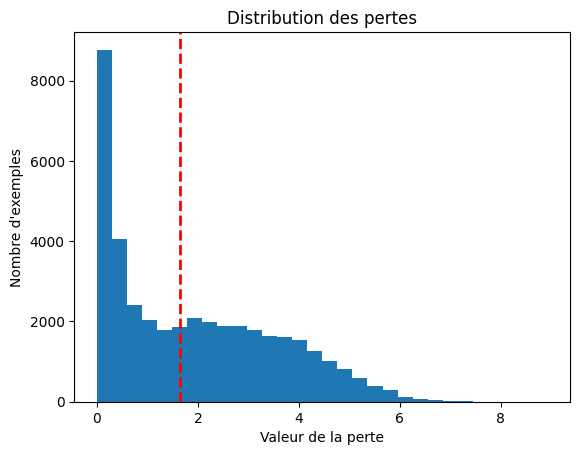

1250/1250 [==============================] - 303s 242ms/step - loss: 2.6920 - accuracy: 0.4421 - val_loss: 2.5610 - val_accuracy: 0.4688 - lr: 1.0000e-04
Epoch 24/200
1250/1250 [==============================] - ETA: 0s - loss: 2.6574 - accuracy: 0.4568
Epoch 24: val_loss did not improve from 2.56097

🔍 Analyse des hard examples après l'époque 23...
📌 20000 exemples sélectionnés (seuil = 1.5267)
🔍 Analyse des prédictions après l'époque 23:
  - Probabilité moyenne max : 0.4625
  - Écart-type des probas max : 0.3052


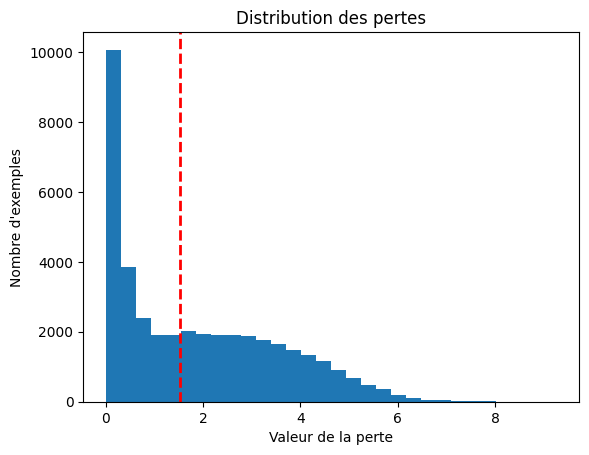

1250/1250 [==============================] - 304s 243ms/step - loss: 2.6574 - accuracy: 0.4568 - val_loss: 2.5699 - val_accuracy: 0.4698 - lr: 1.0000e-04
Epoch 25/200
1250/1250 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.4609
Epoch 25: val_loss improved from 2.56097 to 2.53283, saving model to test.h5

🔍 Analyse des hard examples après l'époque 24...
📌 20000 exemples sélectionnés (seuil = 1.4737)
🔍 Analyse des prédictions après l'époque 24:
  - Probabilité moyenne max : 0.4662
  - Écart-type des probas max : 0.3030


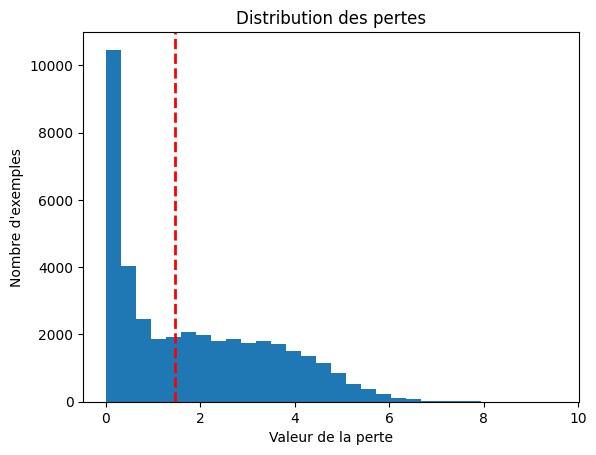

1250/1250 [==============================] - 308s 247ms/step - loss: 2.6380 - accuracy: 0.4609 - val_loss: 2.5328 - val_accuracy: 0.4816 - lr: 1.0000e-04
Epoch 26/200
1250/1250 [==============================] - ETA: 0s - loss: 2.5979 - accuracy: 0.4708
Epoch 26: val_loss did not improve from 2.53283

🔍 Analyse des hard examples après l'époque 25...
📌 20000 exemples sélectionnés (seuil = 1.3685)
🔍 Analyse des prédictions après l'époque 25:
  - Probabilité moyenne max : 0.4764
  - Écart-type des probas max : 0.2999


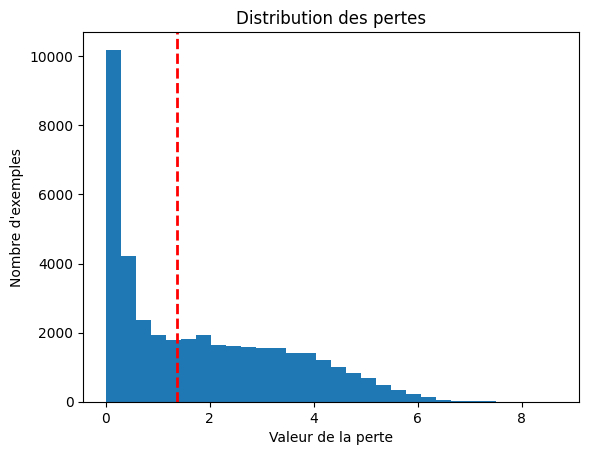

1250/1250 [==============================] - 304s 244ms/step - loss: 2.5979 - accuracy: 0.4708 - val_loss: 2.5334 - val_accuracy: 0.4819 - lr: 1.0000e-04
Epoch 27/200
1250/1250 [==============================] - ETA: 0s - loss: 2.5733 - accuracy: 0.4788
Epoch 27: val_loss did not improve from 2.53283

🔍 Analyse des hard examples après l'époque 26...
📌 20000 exemples sélectionnés (seuil = 1.3474)
🔍 Analyse des prédictions après l'époque 26:
  - Probabilité moyenne max : 0.4854
  - Écart-type des probas max : 0.3013


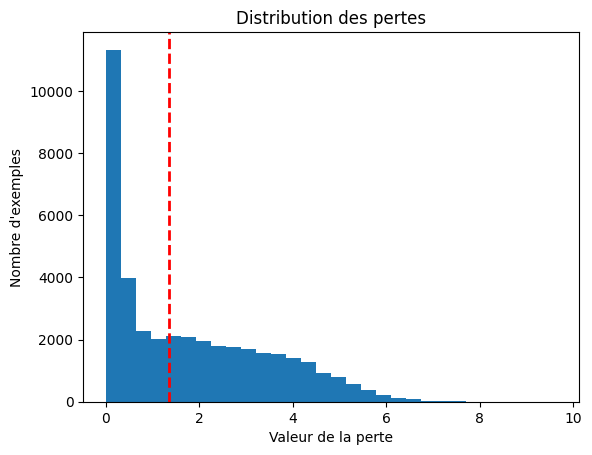

1250/1250 [==============================] - 283s 227ms/step - loss: 2.5733 - accuracy: 0.4788 - val_loss: 2.5540 - val_accuracy: 0.4775 - lr: 1.0000e-04
Epoch 28/200
1250/1250 [==============================] - ETA: 0s - loss: 2.5583 - accuracy: 0.4864
Epoch 28: val_loss did not improve from 2.53283

🔍 Analyse des hard examples après l'époque 27...
📌 20000 exemples sélectionnés (seuil = 1.4290)
🔍 Analyse des prédictions après l'époque 27:
  - Probabilité moyenne max : 0.4811
  - Écart-type des probas max : 0.2982


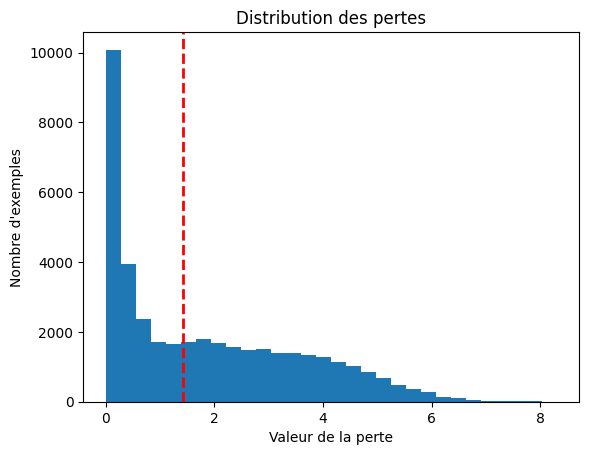

1250/1250 [==============================] - 303s 242ms/step - loss: 2.5583 - accuracy: 0.4864 - val_loss: 2.6037 - val_accuracy: 0.4690 - lr: 1.0000e-04
Epoch 29/200
1250/1250 [==============================] - ETA: 0s - loss: 2.4527 - accuracy: 0.5128
Epoch 29: val_loss improved from 2.53283 to 2.44985, saving model to test.h5

🔍 Analyse des hard examples après l'époque 28...
📌 20000 exemples sélectionnés (seuil = 1.0442)
🔍 Analyse des prédictions après l'époque 28:
  - Probabilité moyenne max : 0.5137
  - Écart-type des probas max : 0.3040


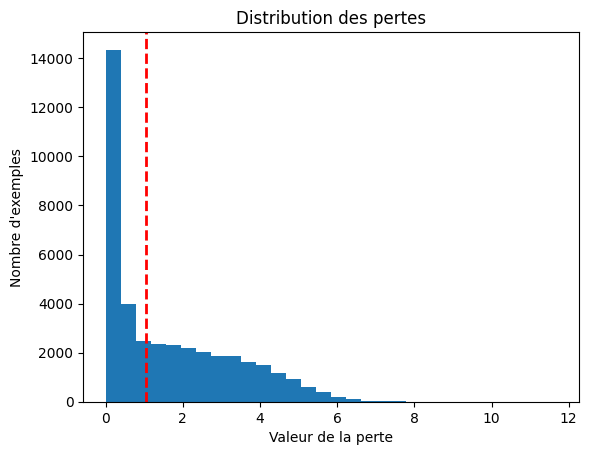

1250/1250 [==============================] - 308s 247ms/step - loss: 2.4527 - accuracy: 0.5128 - val_loss: 2.4498 - val_accuracy: 0.5034 - lr: 1.0000e-05
Epoch 30/200
1250/1250 [==============================] - ETA: 0s - loss: 2.3989 - accuracy: 0.5291
Epoch 30: val_loss improved from 2.44985 to 2.43959, saving model to test.h5

🔍 Analyse des hard examples après l'époque 29...
📌 20000 exemples sélectionnés (seuil = 0.9777)
🔍 Analyse des prédictions après l'époque 29:
  - Probabilité moyenne max : 0.5232
  - Écart-type des probas max : 0.3061


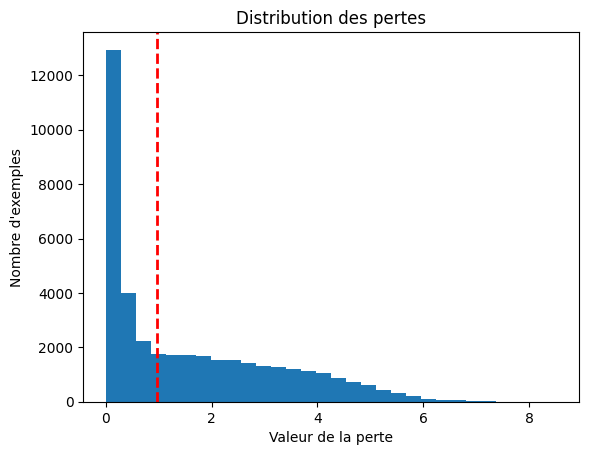

1250/1250 [==============================] - 286s 228ms/step - loss: 2.3989 - accuracy: 0.5291 - val_loss: 2.4396 - val_accuracy: 0.5060 - lr: 1.0000e-05
Epoch 31/200
1250/1250 [==============================] - ETA: 0s - loss: 2.3743 - accuracy: 0.5351
Epoch 31: val_loss improved from 2.43959 to 2.43102, saving model to test.h5

🔍 Analyse des hard examples après l'époque 30...
📌 20000 exemples sélectionnés (seuil = 0.9216)
🔍 Analyse des prédictions après l'époque 30:
  - Probabilité moyenne max : 0.5301
  - Écart-type des probas max : 0.3059


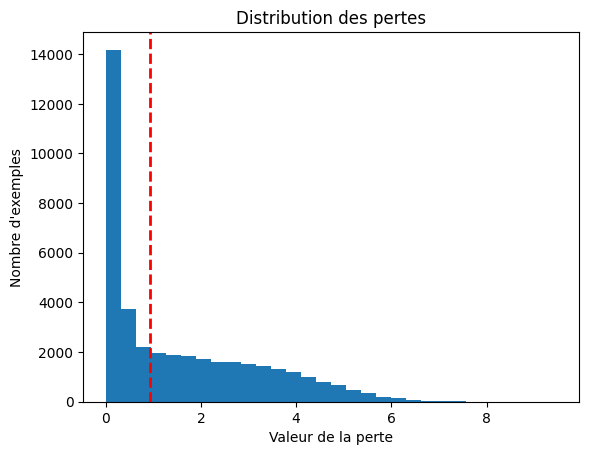

1250/1250 [==============================] - 279s 223ms/step - loss: 2.3743 - accuracy: 0.5351 - val_loss: 2.4310 - val_accuracy: 0.5097 - lr: 1.0000e-05
Epoch 32/200
1250/1250 [==============================] - ETA: 0s - loss: 2.3400 - accuracy: 0.5501
Epoch 32: val_loss improved from 2.43102 to 2.42814, saving model to test.h5

🔍 Analyse des hard examples après l'époque 31...
📌 20000 exemples sélectionnés (seuil = 0.8749)
🔍 Analyse des prédictions après l'époque 31:
  - Probabilité moyenne max : 0.5316
  - Écart-type des probas max : 0.3036


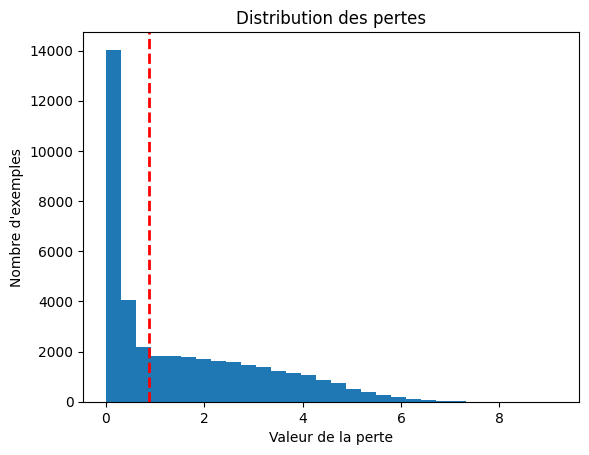

1250/1250 [==============================] - 278s 223ms/step - loss: 2.3400 - accuracy: 0.5501 - val_loss: 2.4281 - val_accuracy: 0.5127 - lr: 1.0000e-05
Epoch 33/200
1250/1250 [==============================] - ETA: 0s - loss: 2.3308 - accuracy: 0.5525
Epoch 33: val_loss improved from 2.42814 to 2.42148, saving model to test.h5

🔍 Analyse des hard examples après l'époque 32...
📌 20000 exemples sélectionnés (seuil = 0.8456)
🔍 Analyse des prédictions après l'époque 32:
  - Probabilité moyenne max : 0.5399
  - Écart-type des probas max : 0.3051


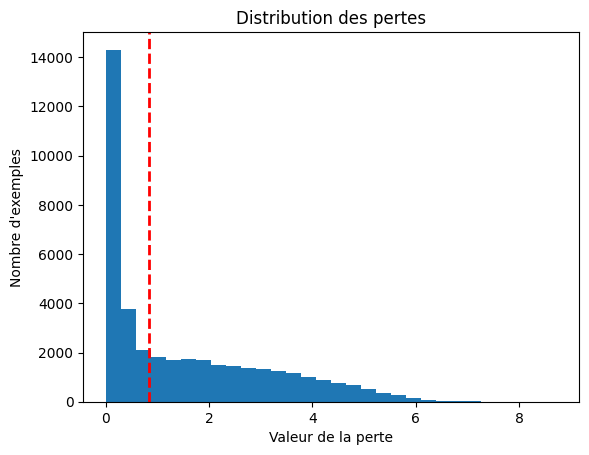

1250/1250 [==============================] - 302s 242ms/step - loss: 2.3308 - accuracy: 0.5525 - val_loss: 2.4215 - val_accuracy: 0.5101 - lr: 1.0000e-05
Epoch 34/200
1250/1250 [==============================] - ETA: 0s - loss: 2.3145 - accuracy: 0.5538
Epoch 34: val_loss improved from 2.42148 to 2.41482, saving model to test.h5

🔍 Analyse des hard examples après l'époque 33...
📌 20000 exemples sélectionnés (seuil = 0.8206)
🔍 Analyse des prédictions après l'époque 33:
  - Probabilité moyenne max : 0.5418
  - Écart-type des probas max : 0.3049


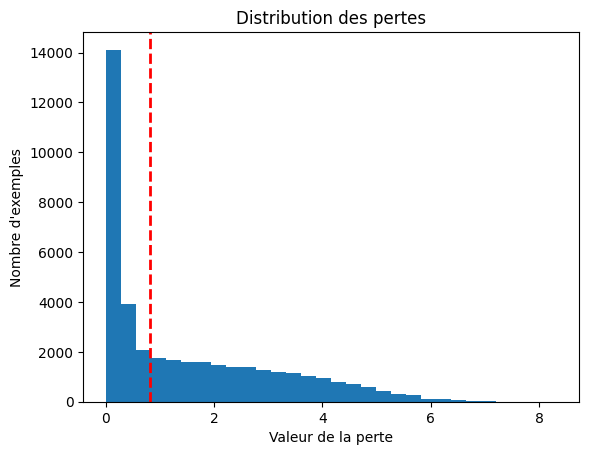

1250/1250 [==============================] - 207s 166ms/step - loss: 2.3145 - accuracy: 0.5538 - val_loss: 2.4148 - val_accuracy: 0.5137 - lr: 1.0000e-05
Epoch 35/200
1250/1250 [==============================] - ETA: 0s - loss: 2.2958 - accuracy: 0.5613
Epoch 35: val_loss did not improve from 2.41482

🔍 Analyse des hard examples après l'époque 34...
📌 20000 exemples sélectionnés (seuil = 0.7810)
🔍 Analyse des prédictions après l'époque 34:
  - Probabilité moyenne max : 0.5450
  - Écart-type des probas max : 0.3047


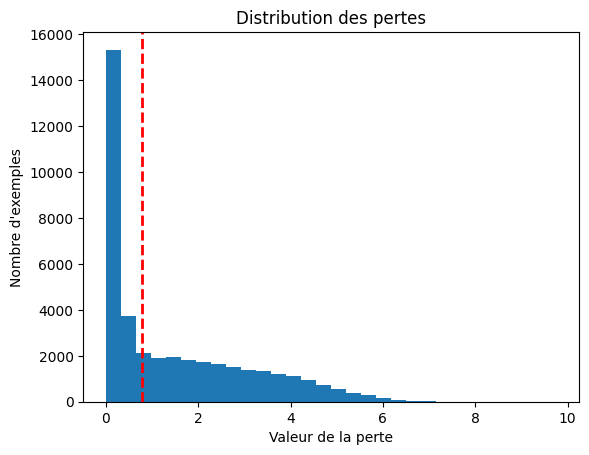

1250/1250 [==============================] - 220s 176ms/step - loss: 2.2958 - accuracy: 0.5613 - val_loss: 2.4160 - val_accuracy: 0.5148 - lr: 1.0000e-05
Epoch 36/200
1250/1250 [==============================] - ETA: 0s - loss: 2.2872 - accuracy: 0.5630
Epoch 36: val_loss improved from 2.41482 to 2.40865, saving model to test.h5

🔍 Analyse des hard examples après l'époque 35...
📌 20000 exemples sélectionnés (seuil = 0.7329)
🔍 Analyse des prédictions après l'époque 35:
  - Probabilité moyenne max : 0.5488
  - Écart-type des probas max : 0.3023


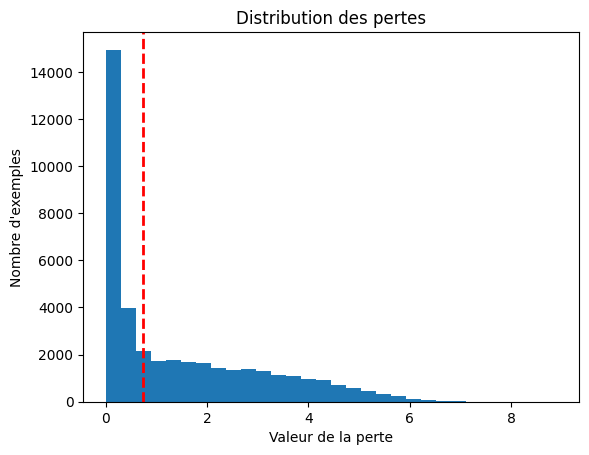

1250/1250 [==============================] - 232s 186ms/step - loss: 2.2872 - accuracy: 0.5630 - val_loss: 2.4086 - val_accuracy: 0.5144 - lr: 1.0000e-05
Epoch 37/200
1250/1250 [==============================] - ETA: 0s - loss: 2.2887 - accuracy: 0.5650
Epoch 37: val_loss did not improve from 2.40865

🔍 Analyse des hard examples après l'époque 36...


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [17]:
model, callback = neural_net(num_neurones=512, num_hidden_layers=3, 
                            dropout_rate=0.4, early_stop_patience=8, 
                            lr_scheduler_patience=3, train_generator=train_generator,
                            learning_rate= 0.0001)

history = training(model=model, cb= callback, n_epoch=200)

plot_history(history=history)

In [ ]:
p_test = pre_process(test)
test_labels = test[b'fine_labels']

In [ ]:
test_generator = create_test_generator(p_test, test_labels, batch_size=32)

In [ ]:
model = load_model("test.h5")

In [ ]:
model.evaluate(test_generator)

156/156 [==============================] - 3s 12ms/step - loss: 2.4075 - accuracy: 0.5320


[2.4075326919555664, 0.5319511294364929]